# Warping

This was a fun little sidetrack, not sure how useful any of it will be in the long run. I was able to calculate and display the warping path pretty easily based on [[Chung]] using FastDTW, but the application side is still fairly unclear. I'm not sure how to:
- apply a penalty so that the path doesn't stray too far from the 1:1 line
- convert the warping path to something actually useful (ie convert it back to depth space)

In [14]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import seaborn as sbn
import matplotlib as mpl
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from cmocean import cm as cmo

In [6]:
float_z = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_z.nc')
float_r = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_rho.nc')

In [4]:
def compute_euclidean_distance_matrix(x, y) -> np.array:
    """Calculate distance matrix
    This method calcualtes the pairwise Euclidean distance between two sequences.
    The sequences can have different lengths.
    """
    dist = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            dist[i,j] = (x[j]-y[i])**2
    return dist

In [5]:
def compute_accumulated_cost_matrix(x, y) -> np.array:
    """Compute accumulated cost matrix for warp path using Euclidean distance
    """
    distances = compute_euclidean_distance_matrix(x, y)

    # Initialization
    cost = np.zeros((len(y), len(x)))
    cost[0,0] = distances[0,0]
    
    for i in range(1, len(y)):
        cost[i, 0] = distances[i, 0] + cost[i-1, 0]  
        
    for j in range(1, len(x)):
        cost[0, j] = distances[0, j] + cost[0, j-1]  

    # Accumulated warp path cost
    for i in range(1, len(y)):
        for j in range(1, len(x)):
            cost[i, j] = min(
                cost[i-1, j],    # insertion
                cost[i, j-1],    # deletion
                cost[i-1, j-1]   # match
            ) + distances[i, j] 
            
    return cost

In [7]:
CT_bar = float_z.CT.mean('N_PROF')
SA_bar = float_z.SA.mean('N_PROF')
SIG0_bar = float_z.SIG0.mean('N_PROF')

In [8]:
num = 100

CT_sample = float_z.CT.isel(N_PROF=num)
SA_sample = float_z.SA.isel(N_PROF=num)
SIG0_sample = float_z.SIG0.isel(N_PROF=num)

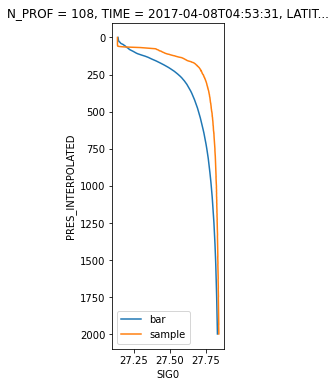

In [9]:
plt.figure(figsize=(2,6))
SIG0_bar.plot(y='PRES_INTERPOLATED', label='bar')
SIG0_sample.plot(y='PRES_INTERPOLATED', label='sample')
plt.gca().invert_yaxis()
plt.legend()

In [10]:
SIG0_matrix = compute_accumulated_cost_matrix(SIG0_bar.values, SIG0_sample.values)

In [11]:
dtw_distance, warp_path = fastdtw(SIG0_bar.values, SIG0_sample.values, radius=1000, dist=euclidean)

In [12]:
# Get the warp path in x and y directions
path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

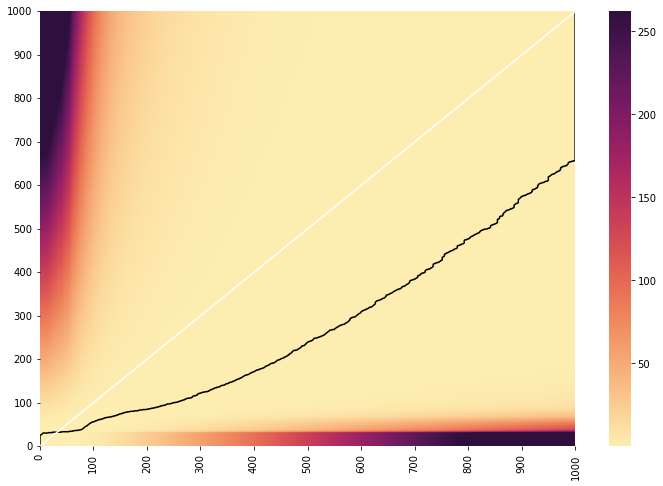

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sbn.heatmap(SIG0_matrix, cmap=cmo.matter, ax=ax, robust=True)
ax.invert_yaxis()

ax.plot(path_xx, path_yy, color='black', linewidth=1.5)
ax.plot([0,1000], [0,1000], color='white', linewidth=1.5)

plt.xticks(range(0,1001,100),range(0,1001,100))
plt.yticks(range(0,1001,100),range(0,1001,100));

A few observations:
- This path deviates pretty significantly from the 1:1 line. [[Chung 2019]] suggested that applying a penalty to keep the warping path from straying too far from the 1:1 line helps with noisy data. How is this actually implemented?
- The biggest question for me is how is this warping path converted to depth offset/heave because it has a different shape.
- Also, I'm a bit worried about the accuracy of this plot because visually the profiles look pretty similar at depth, with the biggest changes between 100m and 1200m. Here, it seems like there's more of a permenant "divergence." I'm wondering if the penalty [[Chung 2019]] suggested could improve this

Another note: I think the best way to tackle this conversion from warp path to depth coordinates is create synthetic sample and reference profiles with a known amount of offset between them, run them through the methods above, and see if we can somehow recover something close to the offset we put in.